<a href="https://colab.research.google.com/github/AmineBAA/Deep-Insights_Neural-Network/blob/main/Resnet_TorchVision_Interpret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretation for Pretrained ResNet Model: Neural activation classification with Autoencoder

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

Captum library privides function of Layer Conductance, that helps to evaluate importance of each neuron within a given Layer

In [1]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [3]:
import matplotlib.pyplot as plt

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [4]:
model = models.resnet18(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.5MB/s]


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [5]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-08-28 06:28:16--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.129.112, 3.5.10.134, 54.231.139.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.129.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2023-08-28 06:28:16 (1.86 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [7]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [43]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/goldfinch_7.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [45]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: brambling ( 0.9412863254547119 )


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [44]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


Predicted: goldfinch ( 0.9933870434761047 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

In [35]:
layer_conv=model.layer3

In [ ]:
layer_conv

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1

In [ ]:
# Convert convolutional layer to fully connected

## 3- Layer Conductance

In [36]:
from captum.attr import LayerConductance

cond = LayerConductance(model, layer_conv)

In [37]:
cond_vals = cond.attribute(input,target=11)  #11 class of 'goldfinch' in imagenet dataset
cond_vals = cond_vals.detach().numpy()

In [ ]:
cond_vals.shape

(1, 256, 14, 14)

In [38]:
cond_vals_flatten=cond_vals.reshape((256,14*14))

In [ ]:
cond_vals_flatten.shape

(256, 196)

In [ ]:
plt.hist(cond_vals[50][0], 100);
plt.title("Neuron 50 Distribution")
plt.figure()
plt.hist(cond_vals[19][0], 100);
plt.title("Neuron 19 Distribution");

In [16]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


Average Neuron Importances
0 :  0.0001
1 :  0.0001
2 :  0.0018
3 :  0.0019
4 :  -0.0002
5 :  -0.0012
6 :  -0.0011
7 :  -0.0000
8 :  -0.0028
9 :  0.0001
10 :  0.0023
11 :  0.0008
12 :  -0.0005
13 :  0.0013
14 :  -0.0007
15 :  0.0012
16 :  0.0001
17 :  0.0001
18 :  -0.0015
19 :  -0.0009
20 :  0.0005
21 :  0.0007
22 :  0.0005
23 :  0.0009
24 :  0.0008
25 :  -0.0001
26 :  0.0005
27 :  -0.0003
28 :  -0.0005
29 :  -0.0001
30 :  0.0006
31 :  0.0004
32 :  -0.0023
33 :  0.0047
34 :  0.0004
35 :  -0.0004
36 :  0.0144
37 :  -0.0002
38 :  -0.0011
39 :  -0.0006
40 :  0.0002
41 :  -0.0016
42 :  0.0021
43 :  0.0006
44 :  0.0016
45 :  0.0013
46 :  0.0003
47 :  -0.0002
48 :  -0.0017
49 :  0.0007
50 :  -0.0009
51 :  0.0002
52 :  0.0017
53 :  -0.0024
54 :  0.0005
55 :  0.0013
56 :  0.0012
57 :  0.0007
58 :  0.0007
59 :  -0.0023
60 :  -0.0015
61 :  0.0022
62 :  0.0005
63 :  0.0008
64 :  0.0003
65 :  -0.0011
66 :  0.0009
67 :  0.0016
68 :  0.0031
69 :  -0.0002
70 :  0.0032
71 :  0.0004
72 :  -0.0001
73 :  

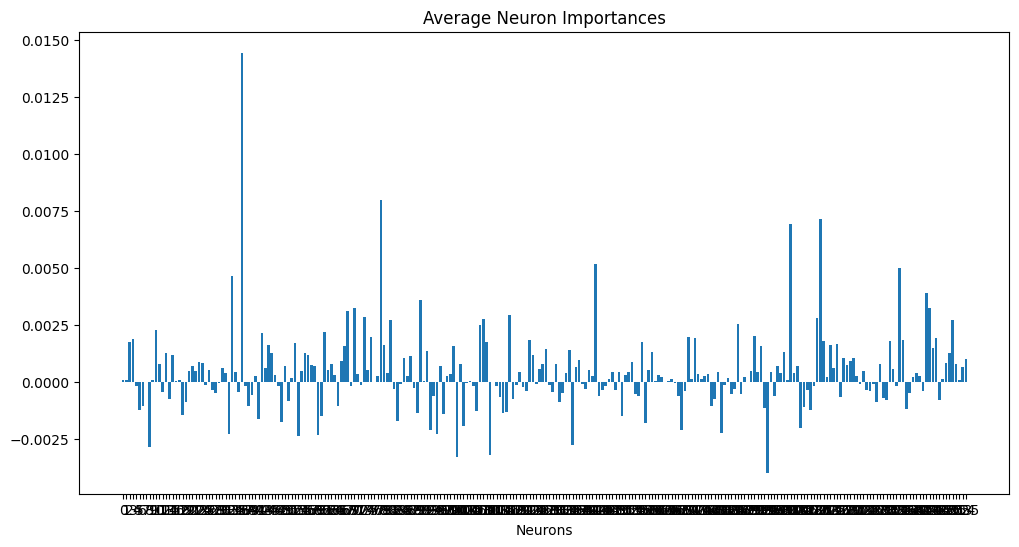

In [39]:
visualize_importances(range(256),np.mean(cond_vals_flatten, axis=1),title="Average Neuron Importances", axis_title="Neurons")

In [ ]:
np.mean(cond_vals_flatten[53,])

-0.0023618995

In [ ]:
vector=[]

for i in range(256):
  vector.append(np.mean(cond_vals_flatten[i,]))



In [ ]:
################################################################################

In [ ]:
merged_array=vector
y=[prediction_score.squeeze().item()]
label=['goldfinch']
for i in range(2,12):
  transform = transforms.Compose([ transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
  transform_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  img = Image.open('/content/goldfinch_'+str(i)+'.jpg')
  transformed_img = transform(img)
  input = transform_normalize(transformed_img)
  input = input.unsqueeze(0)
  output = model(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  y.append(prediction_score.squeeze().item())
  label.append(predicted_label)
  cond_vals = cond.attribute(input,target=11)
  cond_vals = cond_vals.detach().numpy()
  cond_vals_flatten=cond_vals.reshape((256,14*14))
  var=[]
  for j in range(256):
    var.append(np.mean(cond_vals_flatten[j,]))


  merged_array = np.column_stack((merged_array,var))


In [ ]:
merged_array.shape

(256, 11)

In [ ]:
len(label)

11

In [ ]:
############################################################################

In [40]:
## Detect outlier neuron
def detect_outliers_zscore(data, threshold=20):
    z_scores = (data - data.mean()) / data.std()
    return np.where(np.abs(z_scores) > threshold)

outlier_indices = detect_outliers_zscore(cond_vals_flatten)
print("Outlier indices:", outlier_indices)

Outlier indices: (array([36, 36, 68, 90]), array([ 73, 116, 116,  36]))


In [ ]:
outlier_indices[1].shape[0]

4

## 4- Data processing

In [ ]:
import pandas as pd

In [ ]:
X=pd.DataFrame(np.transpose(merged_array))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.000109,0.000089,0.001766,0.001892,-0.000185,-0.001228,-0.001067,-0.000001,-0.002841,0.000081,...,0.001921,-0.000806,0.000151,0.000821,0.001269,0.002734,0.000791,0.000102,0.000679,0.001011
1,-0.001011,0.000528,-0.000319,0.000973,-0.000629,-0.001263,0.000171,-0.000438,-0.000478,0.002498,...,0.000193,0.000027,-0.000038,0.000104,0.000756,0.001301,0.001466,-0.000131,0.000327,0.000565
2,-0.001585,-0.000067,0.000739,0.000322,-0.000390,0.002264,0.002280,-0.000677,0.001402,0.002530,...,0.001617,-0.000890,0.000150,-0.000355,0.000828,0.002478,-0.001540,-0.000709,0.001487,0.000853
3,0.001116,-0.001645,-0.000632,-0.000359,0.000062,0.000914,0.000188,-0.000896,-0.000628,0.000939,...,0.000788,-0.001183,0.000026,0.000569,0.000692,-0.000572,0.001589,-0.000311,0.000727,0.000917
4,-0.000588,-0.000362,0.000072,-0.000187,-0.000256,0.003252,-0.000727,0.000044,0.000318,0.000573,...,0.000939,-0.000972,-0.000234,-0.000588,-0.000389,-0.000430,-0.000673,-0.000219,0.000715,0.000844


In [ ]:
label=pd.DataFrame(label)

In [ ]:
label.columns = ['y']

In [ ]:
data=[X,label]

In [ ]:
X_data=pd.concat(data,axis=1)

In [ ]:
X_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,0.000109,0.000089,0.001766,0.001892,-0.000185,-0.001228,-0.001067,-0.000001,-0.002841,0.000081,...,-0.000806,0.000151,0.000821,0.001269,0.002734,0.000791,0.000102,0.000679,0.001011,1
1,-0.001011,0.000528,-0.000319,0.000973,-0.000629,-0.001263,0.000171,-0.000438,-0.000478,0.002498,...,0.000027,-0.000038,0.000104,0.000756,0.001301,0.001466,-0.000131,0.000327,0.000565,1
2,-0.001585,-0.000067,0.000739,0.000322,-0.000390,0.002264,0.002280,-0.000677,0.001402,0.002530,...,-0.000890,0.000150,-0.000355,0.000828,0.002478,-0.001540,-0.000709,0.001487,0.000853,1
3,0.001116,-0.001645,-0.000632,-0.000359,0.000062,0.000914,0.000188,-0.000896,-0.000628,0.000939,...,-0.001183,0.000026,0.000569,0.000692,-0.000572,0.001589,-0.000311,0.000727,0.000917,0
4,-0.000588,-0.000362,0.000072,-0.000187,-0.000256,0.003252,-0.000727,0.000044,0.000318,0.000573,...,-0.000972,-0.000234,-0.000588,-0.000389,-0.000430,-0.000673,-0.000219,0.000715,0.000844,1


In [ ]:
X_data["y"]=X_data["y"].astype('category')
X_data["y"]=X_data["y"].cat.codes

## 5- Data preparation

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dense, BatchNormalization, Activation, Add

In [ ]:
x_train=X_data.loc[:, X_data.columns != 'y']

In [ ]:
y_train=X_data['y']

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [ ]:
scaler = MinMaxScaler()
x_train=scaler.fit_transform(x_train)

In [ ]:
x_train.shape[1]

256

## 6- Autoencoder classifier

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras import layers
import tensorflow as tf
from keras import regularizers

In [ ]:
encoding_dim=2
input=x_train.shape[1]
# Deep NN
input_img = keras.Input(shape=(input,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
Total params: 66,562
Trainable params: 66,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_train, x_train)
                )

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6933 - val_loss: 0.6930
Epoch 2/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 4/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6926 - val_loss: 0.6922
Epoch 5/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6922 - val_loss: 0.6917
Epoch 6/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6917 - val_loss: 0.6911
Epoch 7/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6911 - val_loss: 0.6904
Epoch 8/20
1/1 [==============================] - 0s 37ms/step - loss: 0.6904 - val_loss: 0.6896
Epoch 9/20
1/1 [==============================] - 0s 34ms/step - loss: 0.6896 - val_loss: 0.6887
Epoch 10/20
1/1 [==============================] - 0s 36ms/step - loss: 0.6887 - val_loss: 0.6876
Epoch 11/20
1/1 [==============

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_train)


1/1 [==============================] - 0s 79ms/step


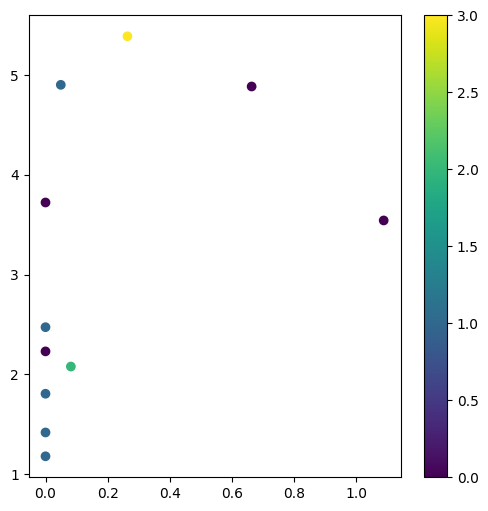

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_train)
plt.colorbar()
plt.show()

In [ ]:
encoded_imgs

array([[0.        , 1.1805845 ],
       [0.        , 1.4192028 ],
       [0.        , 1.8069705 ],
       [0.        , 2.231181  ],
       [0.        , 2.4735572 ],
       [1.0888935 , 3.5423849 ],
       [0.        , 3.7223573 ],
       [0.08171002, 2.0792823 ],
       [0.04924046, 4.9006853 ],
       [0.6636663 , 4.884096  ],
       [0.26376823, 5.3869643 ]], dtype=float32)